# Fit global epistasis models to DMS expression data

The [`dms_variants.globalepistasis`](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis) module is based off the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214) -- that there exists an underlying latent phenotype that mutations affect additively, and
then an observed (measured) phenotype that is a non-linear
function of the latent phenotype.


## Setup for analysis

Import Python modules / packages:

In [1]:
import collections
import os
import itertools
import random
import tempfile
import time
import warnings

import Bio.SeqIO

from IPython.display import display, HTML

import numpy
import pandas as pd

from plotnine import *

import dms_variants.binarymap
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

import yaml

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html):

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using dms_variants version {dms_variants.__version__}")

Using dms_variants version 0.8.9


Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

### Parameters for notebook
Read the configuration file:

In [6]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed:

In [7]:
os.makedirs(config['global_epistasis_expr_dir'], exist_ok=True)
os.makedirs(config['figs_dir'], exist_ok=True)

## Read in Sort-seq expression mean fluorescence scores by `barcode`
Read in Sort-seq expression measurements. I will first fit global epistasis models using the ML_meanF measurements. Rename meanF column to be func_score, and var column to func_score_var. Remove rows with NaN for func_score. For empty aa_substitutions (wildtype), it is being replaced with NA. Make back to an empty string.

Remove anything that is a disallowed mutation, and not part of the planned library design. 
Because I was having a hard time getting this to work by reassigning the `allowed_mutant` column based on the list of mutations that we designed into the library, I will instead go the more circuitous route of reinitializing the original CodonVariantTable (which does have the `allowed_mutant` as `extra_cols`) and merging with the functional scores data frame. 

In [8]:
wt_seqrecord = Bio.SeqIO.read(config['wildtype_sequence'], 'fasta')
geneseq = str(wt_seqrecord.seq)
primary_target = wt_seqrecord.name
print(f"Read sequence of {len(geneseq)} nt for {primary_target} from {config['wildtype_sequence']}")
      
print(f"Initializing CodonVariantTable from gene sequence and {config['codon_variant_table']}")

variants = dms_variants.codonvarianttable.CodonVariantTable(
                geneseq=geneseq,
                barcode_variant_file=config['codon_variant_table'],
                substitutions_are_codon=True,
                substitutions_col='codon_substitutions',
                extra_cols=['aa_subs_list', 'allowed_mutant'],
                primary_target=primary_target)

variant_df = variants.barcode_variant_df[['barcode','library', 'allowed_mutant']]

Read sequence of 603 nt for SARS-CoV-2 from data/wildtype_sequence.fasta
Initializing CodonVariantTable from gene sequence and results/variants/codon_variant_table.csv


In [9]:
print(f'Total number of variants in CodonVariantTable between the two libraries:')
print(len(variant_df))
print(f'Number of allowed variants in CodonVariantTable between the two libraries:')
print(len(variant_df.query('allowed_mutant')))

Total number of variants in CodonVariantTable between the two libraries:
98612
Number of allowed variants in CodonVariantTable between the two libraries:
90116


In [10]:
display(HTML(variant_df.head().to_html()))

,barcode,library,allowed_mutant
0,AAAAAAAAAAAAAATA,lib1,True
1,AAAAAAAAAAAACCTA,lib1,True
2,AAAAAAAAACAATAGT,lib1,False
3,AAAAAAAAACACCATT,lib1,True
4,AAAAAAAAACACCTGG,lib1,True


First, just examine the correlations between functional scores for the 2 libraries. 

In [11]:
func_scores = (pd.read_csv(config['expression_sortseq_file'])
               .merge(variant_df, on=['barcode', 'library'], how='left', validate='many_to_one')
               .query('allowed_mutant')
               .rename(columns={'delta_ML_meanF':'func_score','var_ML_meanF':'func_score_var'})
               .dropna(subset=['func_score'])
               .fillna('')
     )
display(HTML(func_scores.head(2).to_html()))

,library,barcode,variant_call_support,total_count,ML_meanF,func_score,func_score_var,variant_class,aa_substitutions,n_aa_substitutions,allowed_mutant
1,lib1,AAAAAAAAAAAACCTA,1,35.22,8.04,-2.59,0.05,>1 nonsynonymous,E10K R16E K48E K87E G116K F126K G146D E154K Q163K G174D,10,True
3,lib1,AAAAAAAAACACCATT,7,128.03,9.79,-0.85,0.02,>1 nonsynonymous,E10K R16E Y39E K87E L122R F126K K132E G146D E154K F156K Q168R G174D,12,True


I'm actually curious to see if the func_scores are by aa_substitutions or by barcode

In [12]:
display(HTML(func_scores
             .query('aa_substitutions=="E10K"')
             .head()
             .to_html()
            )
       )

,library,barcode,variant_call_support,total_count,ML_meanF,func_score,func_score_var,variant_class,aa_substitutions,n_aa_substitutions,allowed_mutant
892,lib1,AAAATTAGGTTCCGCA,3,25.33,10.23,-0.40,0.06,1 nonsynonymous,E10K,1,True
4168,lib1,AAGAAGCTATACGCTA,5,48.23,10.22,-0.41,0.04,1 nonsynonymous,E10K,1,True
5896,lib1,AATATTGAAAGTCCCT,5,147.40,10.33,-0.30,0.02,1 nonsynonymous,E10K,1,True
6435,lib1,AATGGGAAATACATAC,6,62.06,10.03,-0.60,0.03,1 nonsynonymous,E10K,1,True
9241,lib1,ACCTCGAACTACAATG,6,87.02,10.28,-0.35,0.03,1 nonsynonymous,E10K,1,True


Pearson's R=0.64; N=6973


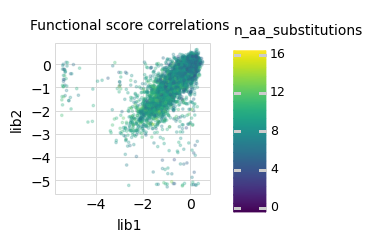

In [13]:
func_score_corr=(func_scores
 [['aa_substitutions', 'n_aa_substitutions', 'library','func_score']]
 .pivot_table(index=['aa_substitutions','n_aa_substitutions',],
                     values='func_score',
                     columns='library',
                     )
 .dropna()
 .reset_index()
)

corrs = (
        func_score_corr
        [['lib1', 'lib2']]
        .corr(method='pearson')
        .reset_index()
        ).at[0,'lib2'].round(2).astype(str)

print(f"Pearson's R={corrs}; N={len(func_score_corr)}")

p = (
        ggplot(func_score_corr, aes('lib1', 'lib2', color='n_aa_substitutions')) +
        geom_point(alpha=0.25, size=0.5) +
        theme(figure_size=(2,2),
              )
    +ggtitle('Functional score correlations')
        )
_ = p.draw()

## Fit global epistasis models to ML meanF
We now fit global epistasis models to the functional scores.
For background on these models, see [Otwinoski et al (2018)](https://www.pnas.org/content/115/32/E7550).
The models we fits are implemented in [dms_variants.globalepistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html), which has extensive documentation.

The primary model of interest is [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis), which assumes that the observed phenotype is a monotonic non-linear function of an underlying additive latent phenotype.
As a control, we also fit a [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) model, which assumes that mutations simply contribute additively to the observed phenotype:

For the fitting, we first convert the set of functional scores into a binary representation using a [BinaryMap]((https://jbloomlab.github.io/dms_variants/dms_variants.binarymap.html#dms_variants.binarymap.BinaryMap)).
Then we create the model, fit it, and store it.

In [14]:
# NBVAL_IGNORE_OUTPUT

models = {}  # store models, keyed by `(epistasistype, likelihoodtype, sample, lib)`

for (lib), scores in func_scores.groupby(['library']):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    for epistasistype, likelihoodtype, Model in [
            ('global epistasis', 'Gaussian', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no epistasis', 'Gaussian', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ('global epistasis', 'Cauchy', dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('no epistasis', 'Cauchy', dms_variants.globalepistasis.NoEpistasisCauchyLikelihood),
            ]:
        print(f"Fitting {epistasistype} with {likelihoodtype} likelihood model to {lib}...", end=' ')
    
        start = time.time()
        model = Model(bmap)
        model.fit()  # do NOT change ftol in normal use, this is just for test
        print(f"fitting took {time.time() - start:.1f} sec.")
        models[(epistasistype, likelihoodtype, lib)] = model

Fitting global epistasis with Gaussian likelihood model to lib1... fitting took 0.5 sec.
Fitting no epistasis with Gaussian likelihood model to lib1... fitting took 0.5 sec.
Fitting global epistasis with Cauchy likelihood model to lib1... fitting took 0.4 sec.
Fitting no epistasis with Cauchy likelihood model to lib1... fitting took 0.6 sec.
Fitting global epistasis with Gaussian likelihood model to lib2... fitting took 0.3 sec.
Fitting no epistasis with Gaussian likelihood model to lib2... fitting took 0.2 sec.
Fitting global epistasis with Cauchy likelihood model to lib2... fitting took 6.8 sec.
Fitting no epistasis with Cauchy likelihood model to lib2... fitting took 0.3 sec.


Now we want to see which model fits the data better.
To do this, we get the log likelihood of each model along with the number of model parameters and use it to calculate the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion).
Models with lower AIC are better, and below we see that the **linear models**, not the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis model always fits the data much better:

In [15]:
# NBVAL_IGNORE_OUTPUT

logliks_df = (
    pd.DataFrame.from_records(
            [(epistasistype, likelihoodtype, lib, model.nparams, model.loglik) for
             (epistasistype, likelihoodtype, lib), model in models.items()],
            columns=['model', 'likelihood type', 'library',
                     'n_parameters', 'log_likelihood']
            )
    .assign(AIC=lambda x: 2 * x['n_parameters'] - 2 * x['log_likelihood'])
    .set_index(['library'])
    )

display(HTML(logliks_df.round(1).to_html()))

,model,likelihood type,n_parameters,log_likelihood,AIC
library,,,,,
lib1,global epistasis,Gaussian,26,-48023.4,96098.8
lib1,no epistasis,Gaussian,20,-33119.0,66278.0
lib1,global epistasis,Cauchy,26,-49117.1,98286.2
lib1,no epistasis,Cauchy,20,-19786.1,39612.1
lib2,global epistasis,Gaussian,26,-40431.8,80915.5
lib2,no epistasis,Gaussian,20,-27718.7,55477.5
lib2,global epistasis,Cauchy,26,-16732.3,33516.6
lib2,no epistasis,Cauchy,20,-20816.5,41673.0


In [16]:
# check to whether the global epistasis model is better in all cases
display(HTML(logliks_df
        .reset_index()
        .pivot_table(index=['library'],
                     values='AIC',
                     columns='model'
                     )
        .assign(global_better=lambda x: x['global epistasis'] < x['no epistasis'])
             .to_html()
        ))

model,global epistasis,no epistasis,global_better
library,,,
lib1,97192.50166,52945.074213,False
lib2,57216.05690,48575.224840,False


We see that actually the linear, non-epistatic models are better.


Next, we will examine how the model looks on all the actual variants used to fit the model.
We use [AbstractEpistasis.phenotypes_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.phenotypes_df) to get a data frame of all the variants used to fit each epistasis model along with their functional scores and the latent and observed phenotypes predicted by each model.

In [17]:
# NBVAL_IGNORE_OUTPUT

variants_df = (pd.concat(
        [model.phenotypes_df
         .assign(library=lib,
                 likelihoodtype=likelihoodtype,
                 epistasistype=epistasistype,
                 )
         for (epistasistype, likelihoodtype, lib), model in models.items()
#          if (epistasistype == 'global epistasis')
        ],
        ignore_index=True, sort=False)
               .assign(n_aa_substitutions=lambda x: x['aa_substitutions'].str.split()
                       .map(lambda s: len(s)),
                       n_subs_bin=lambda x: x['n_aa_substitutions']
                       .map(lambda s:(s==0 and '0') or (s==1 and '1') or (s<4 and '2-4') or (s<=8 and '5-8') or (s>8 and '9+')
                           )
                      )
              )

predictionsfile = config['expression_predictions_by_aa_substitutions_file']
variants_df.to_csv(predictionsfile, index=False)
print(f"Writing predictions to {predictionsfile}")

display(HTML(variants_df.head().round(2).to_html()))

Writing predictions to results/global_epistasis_expression/expression_predictions_by_aa_substitutions.csv


,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,library,likelihoodtype,epistasistype,n_aa_substitutions,n_subs_bin
0,E10K R16E K48E K87E G116K F126K G146D E154K Q163K G174D,-2.59,0.05,8.86,-0.63,lib1,Gaussian,global epistasis,10,9+
1,E10K R16E Y39E K87E L122R F126K K132E G146D E154K F156K Q168R G174D,-0.85,0.02,12.90,-0.63,lib1,Gaussian,global epistasis,12,9+
2,K48E K56E G116K K132E E154K F156K Q168R,-0.34,0.05,7.72,-0.63,lib1,Gaussian,global epistasis,7,5-8
3,K48E K56E K87E G116K L122R K132E G146D E154K Q163K G174D,-2.24,0.03,9.95,-0.63,lib1,Gaussian,global epistasis,10,9+
4,Y39E K56E F126K K132E E154K Q163K Q168R G174D,0.23,0.05,9.30,-0.63,lib1,Gaussian,global epistasis,8,5-8


In [18]:
models_by_barcode = (variants_df
                     .drop(columns=['func_score', 'func_score_var'])
                     .drop_duplicates()
                     .merge(func_scores.dropna(subset=['func_score'])[['barcode', 'func_score', 'func_score_var', 'aa_substitutions', 'library']], 
                      how='right',
                      on=['aa_substitutions', 'library'],
                      validate='many_to_many',
                     )
              )

models_by_barcode_file = config['expression_predictions_by_barcode_file']
variants_df.to_csv(models_by_barcode_file, index=False)
print(f"Writing predictions to {models_by_barcode_file}")

display(HTML(models_by_barcode.head().round(2).to_html()))

Writing predictions to results/global_epistasis_expression/expression_predictions_by_barcode.csv


,aa_substitutions,latent_phenotype,observed_phenotype,library,likelihoodtype,epistasistype,n_aa_substitutions,n_subs_bin,barcode,func_score,func_score_var
0,E10K R16E K48E K87E G116K F126K G146D E154K Q163K G174D,8.86,-0.63,lib1,Gaussian,global epistasis,10,9+,AAAAAAAAAAAACCTA,-2.59,0.05
1,E10K R16E K48E K87E G116K F126K G146D E154K Q163K G174D,-1.89,-1.89,lib1,Gaussian,no epistasis,10,9+,AAAAAAAAAAAACCTA,-2.59,0.05
2,E10K R16E K48E K87E G116K F126K G146D E154K Q163K G174D,8.60,-0.44,lib1,Cauchy,global epistasis,10,9+,AAAAAAAAAAAACCTA,-2.59,0.05
3,E10K R16E K48E K87E G116K F126K G146D E154K Q163K G174D,-1.71,-1.71,lib1,Cauchy,no epistasis,10,9+,AAAAAAAAAAAACCTA,-2.59,0.05
4,E10K R16E Y39E K87E L122R F126K K132E G146D E154K F156K Q168R G174D,12.90,-0.63,lib1,Gaussian,global epistasis,12,9+,AAAAAAAAACACCATT,-0.85,0.02


In [19]:
print(len(variants_df))
print(len(variants_df)/4)
print(len(models_by_barcode))
print(len(models_by_barcode)/4)
print(len(func_scores))

dup_barcodes = (
    models_by_barcode
    .groupby(['library', 'barcode', 'epistasistype', 'likelihoodtype'])
    .size()
    .rename('duplicate_count')
    .reset_index()
    .query('duplicate_count > 1')
    )

display(HTML(dup_barcodes.head().to_html(index=False)))
print(dup_barcodes['duplicate_count'].sum())

311156
77789.0
311156
77789.0
77789


library,barcode,epistasistype,likelihoodtype,duplicate_count


0


Now let's see what the expression scores look like for each of the 4 models, when the x-axis is number of aa subs.

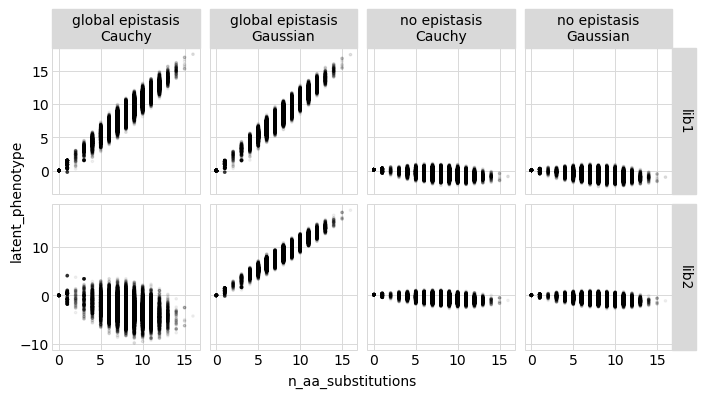

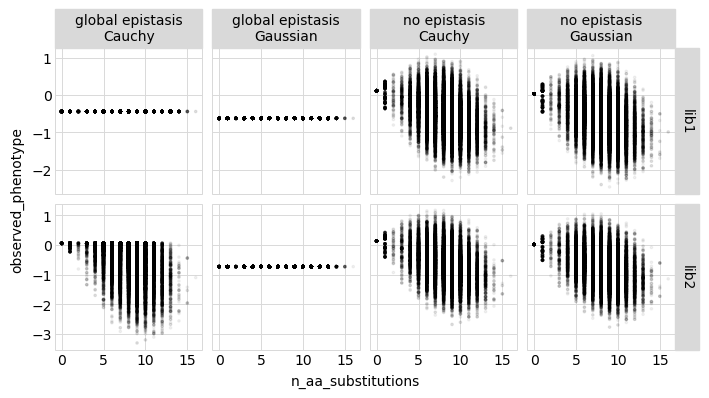

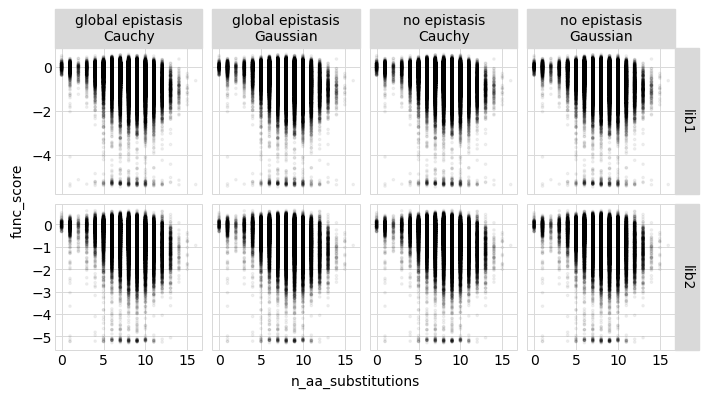

In [20]:
for y in ['latent_phenotype','observed_phenotype','func_score']:
    p = (
        ggplot(variants_df, aes('n_aa_substitutions', y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library ~ epistasistype+likelihoodtype', scales='free') +
        theme(figure_size=(4 * variants_df['likelihoodtype'].nunique(),
                           2 * variants_df['library'].nunique()),
              )
        )
    _ = p.draw()

Plot library correlations between model predictions. Here are the models:
* Cauchy, epistasis
* Gaussian, epistasis
* Cauchy, linear
* Gaussian, linear

For each model, we should compare:
* func_score
* latent_phenotype
* observed_phenotype

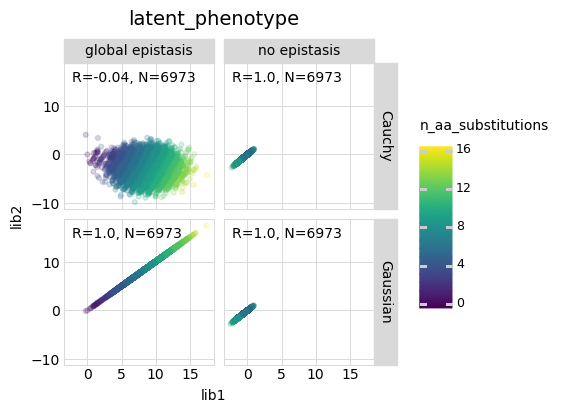

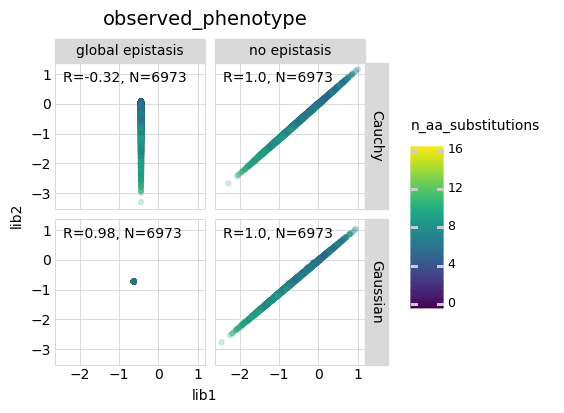

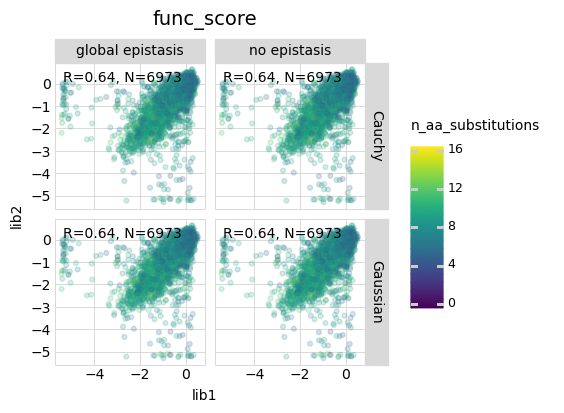

In [21]:
libraries = [lib for lib in variants_df['library'].unique() if lib != "average"]
assert len(libraries) == 2, 'plot only makes sense if 2 libraries'

for phenotype in ['latent_phenotype','observed_phenotype','func_score']:

    # wide data frame with each library's score in a different column
    df_wide = (
        variants_df
        [['library', 'aa_substitutions', 'n_aa_substitutions', 'n_subs_bin', 'likelihoodtype', 'epistasistype', phenotype]]
        # now make columns for each library, only keep mutants with scores for both libs
        .pivot_table(index=['aa_substitutions', 'n_aa_substitutions', 'n_subs_bin', 'likelihoodtype', 'epistasistype'],
                     columns='library',
                     values=phenotype)
        .reset_index()
        .dropna(axis=0)
        )

    # correlations between libraries
    corrs = (
        df_wide
        .groupby(['likelihoodtype', 'epistasistype'])
        [libraries]
        .corr(method='pearson')
        .reset_index()
        .query('library == @libraries[0]')
        .assign(correlation=lambda x: 'R=' + x[libraries[1]].round(2).astype(str))
        [['likelihoodtype', 'epistasistype', 'correlation']]
        # add number of mutations measured
        .merge(df_wide
               .groupby(['likelihoodtype', 'epistasistype'])
               .size()
               .rename('n')
               .reset_index()
               )
        .assign(correlation=lambda x: x['correlation'] + ', N=' + x['n'].astype(str))
        )

    # plot correlations
    xmin = df_wide[libraries[0]].min()
    xspan = df_wide[libraries[0]].max() - xmin
    ymin = df_wide[libraries[1]].min()
    yspan = df_wide[libraries[1]].max() - ymin
    p = (ggplot(df_wide) +
         aes(libraries[0], libraries[1]) +
         geom_point(aes(color='n_aa_substitutions'), alpha=0.2, ) +
         geom_text(mapping=aes(label='correlation'),
                   data=corrs,
                   x=0.01 * xspan + xmin,
                   y=0.99 * yspan + ymin,
                   size=10,
                   ha='left',
                   va='top',
                   ) +
         facet_grid('likelihoodtype ~ epistasistype') +
         theme(figure_size=(4,4),
               plot_title=element_text(size=14)) +
         ggtitle(f"{phenotype}")
         )

    __ = p.draw()

Below we plot the relationships among the latent phenotype from the model, the observed phenotype from the model, and the measured functional score for all variants used to fit the model:

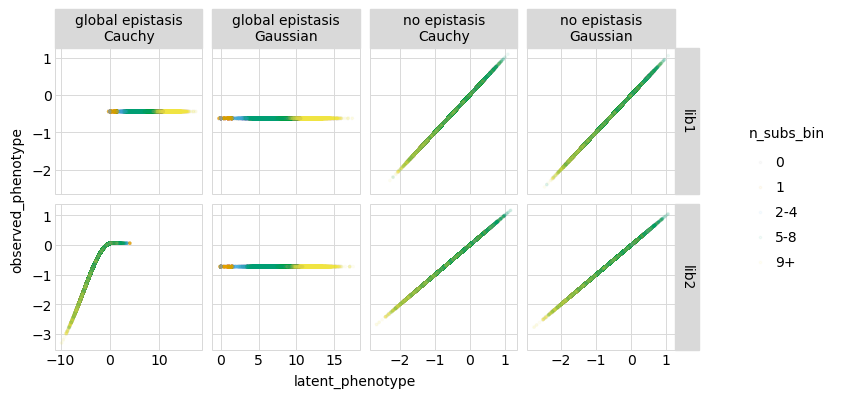

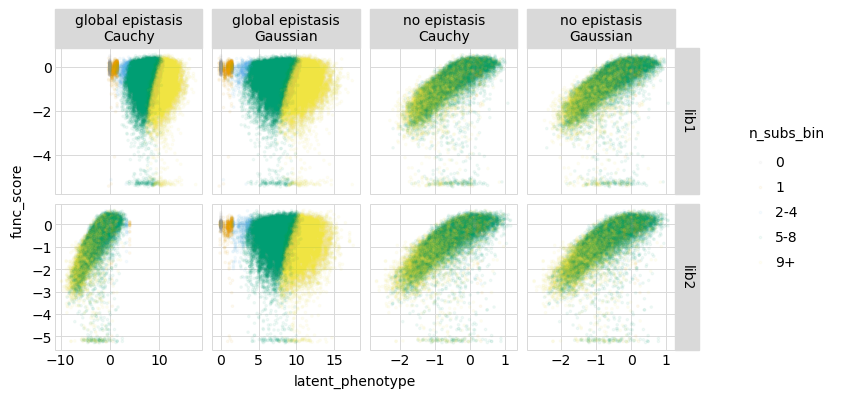

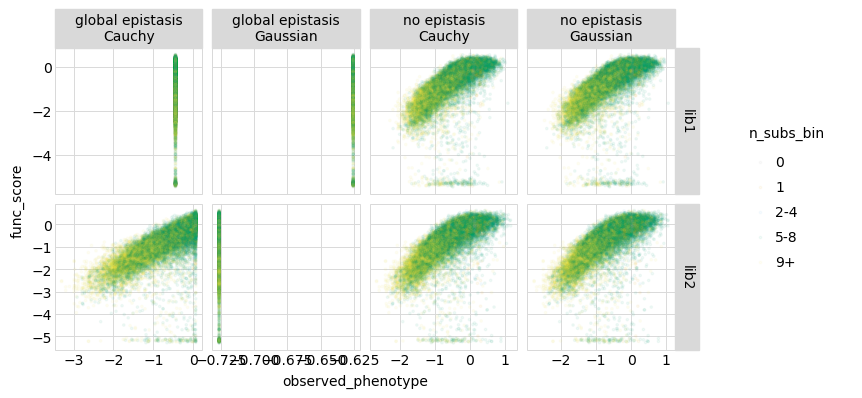

In [22]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df, aes(x, y, color='n_subs_bin')) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library ~ epistasistype+likelihoodtype', scales='free') +
        theme(figure_size=(4 * variants_df['likelihoodtype'].nunique(),
                           2 * variants_df['library'].nunique()),
              )
        +scale_color_manual(values=CBPALETTE)
        )
    _ = p.draw()

If we look at the shape of the curve for the global epistasis modesl, I think we can conclude that those models are not fitting the data well at all.
We can see that in 3/4 cases, the latent phenotype goes up with higher-order mutants, even as the functional score goes down. This makes no sense.

To get a better view into the "shape" of global epistasis, let's re-make the plots above but only showing single mutant barcodes.

In [23]:
mask = (variants_df['aa_substitutions'].str.len() < 6) & (variants_df['aa_substitutions'].str.len() > 0)
single_variants_df = variants_df.loc[mask]
display(HTML(single_variants_df
            .query('likelihoodtype==@likelihoodtype & epistasistype==@epistasistype')
            .query('library=="lib1" & aa_substitutions=="E10K"')
            .head()
            .to_html()
           )
      )

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,library,likelihoodtype,epistasistype,n_aa_substitutions,n_subs_bin
131375,E10K,-0.40,0.06,-0.361588,-0.361588,lib1,Cauchy,no epistasis,1,1
133917,E10K,-0.41,0.04,-0.361588,-0.361588,lib1,Cauchy,no epistasis,1,1
135255,E10K,-0.30,0.02,-0.361588,-0.361588,lib1,Cauchy,no epistasis,1,1
135677,E10K,-0.60,0.03,-0.361588,-0.361588,lib1,Cauchy,no epistasis,1,1
137870,E10K,-0.35,0.03,-0.361588,-0.361588,lib1,Cauchy,no epistasis,1,1


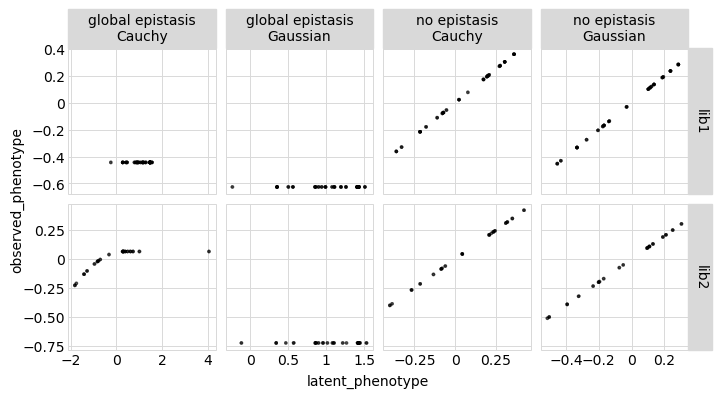

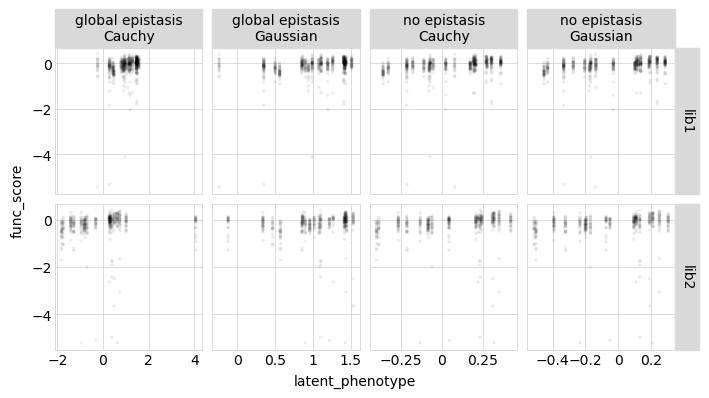

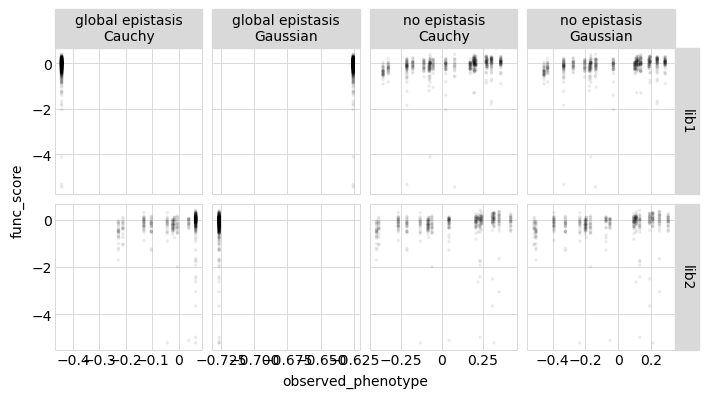

In [24]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(single_variants_df, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library ~ epistasistype+likelihoodtype', scales='free') +
        theme(figure_size=(4 * variants_df['likelihoodtype'].nunique(),
                           2 * variants_df['library'].nunique()),
              )
        )
    _ = p.draw()

In [25]:
# #add predicted and latent phenotypes to table by barcode with additional columns used for interpretation
# dt = pd.read_csv(config['expression_sortseq_file'])
# dt[['aa_substitutions']] = dt[['aa_substitutions']].fillna(value='')

# dt = models.get(('global epistasis', 'Gaussian','lib1')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Gaussian_1',observed_phenotype_col='predicted_phenotype_Gaussian_1',unknown_as_nan=True)
# dt = models.get(('global epistasis', 'Cauchy', 'lib1')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Cauchy_1',observed_phenotype_col='predicted_phenotype_Cauchy_1',unknown_as_nan=True)
# dt = models.get(('global epistasis', 'Gaussian', 'lib2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Gaussian_2',observed_phenotype_col='predicted_phenotype_Gaussian_2',unknown_as_nan=True)
# dt = models.get(('global epistasis', 'Cauchy', 'lib2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Cauchy_2',observed_phenotype_col='predicted_phenotype_Cauchy_2',unknown_as_nan=True)

# dt.to_csv(config['global_epistasis_expr_file'], index=False)
# print(f"Writing predictions to {config['global_epistasis_expr_file']}")

## Repeat fits for pooled library measurements

Repeat the fits for all barcodes pooled together. There is slight variation in the average mean fluorescence ascribed to wildtype genotypes in each library. 

In [26]:
df_joint = pd.read_csv(config['expression_sortseq_file'])
df_joint.rename(columns={'delta_ML_meanF':'func_score','var_ML_meanF':'func_score_var'},inplace=True)
func_scores_joint = df_joint[pd.notnull(df_joint['func_score'])]
func_scores_joint.fillna('',inplace=True)
display(HTML(func_scores_joint.head().to_html()))

,library,barcode,variant_call_support,total_count,ML_meanF,func_score,func_score_var,variant_class,aa_substitutions,n_aa_substitutions
1,lib1,AAAAAAAAAAAACCTA,1,35.22,8.04,-2.59,0.05,>1 nonsynonymous,E10K R16E K48E K87E G116K F126K G146D E154K Q163K G174D,10
2,lib1,AAAAAAAAACAATAGT,4,37.36,8.89,-1.74,0.05,>1 nonsynonymous,R16E K48E K56E T100A G116K L122R F126K K132E G146D E154K Q168R G174D,12
3,lib1,AAAAAAAAACACCATT,7,128.03,9.79,-0.85,0.02,>1 nonsynonymous,E10K R16E Y39E K87E L122R F126K K132E G146D E154K F156K Q168R G174D,12
4,lib1,AAAAAAAAACACCTGG,2,39.07,10.29,-0.34,0.05,>1 nonsynonymous,K48E K56E G116K K132E E154K F156K Q168R,7
5,lib1,AAAAAAAAATAGGCAC,7,65.85,8.39,-2.24,0.03,>1 nonsynonymous,K48E K56E K87E G116K L122R K132E G146D E154K Q163K G174D,10


In [27]:
# NBVAL_IGNORE_OUTPUT

models_joint = {}  # store models, keyed by `(epistasistype, likelihoodtype)`

# for (target), scores in func_scores_joint.groupby(['target']):
   
bmap = dms_variants.binarymap.BinaryMap(func_scores_joint)

for epistasistype, likelihoodtype, Model in [
        ('global epistasis', 'Gaussian', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
        ('no epistasis', 'Gaussian', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
        ('global epistasis', 'Cauchy', dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
        ('no epistasis', 'Cauchy', dms_variants.globalepistasis.NoEpistasisCauchyLikelihood),
        ]:
    print(f"Fitting {epistasistype} with {likelihoodtype} likelihood model...", end=' ')

    start = time.time()
    model = Model(bmap)
    model.fit()  # do NOT change ftol in normal use, this is just for test
    print(f"fitting took {time.time() - start:.1f} sec.")
    models_joint[(epistasistype, likelihoodtype)] = model



Fitting global epistasis with Gaussian likelihood model... fitting took 82.6 sec.
Fitting no epistasis with Gaussian likelihood model... fitting took 1.1 sec.
Fitting global epistasis with Cauchy likelihood model... fitting took 561.8 sec.
Fitting no epistasis with Cauchy likelihood model... fitting took 17.1 sec.


In [28]:
# NBVAL_IGNORE_OUTPUT

variants_df_joint = (pd.concat(
        [model.phenotypes_df
         .assign(likelihoodtype=likelihoodtype,
                 epistasistype=epistasistype
                )
         for (epistasistype, likelihoodtype), model in models_joint.items()
#          if (epistasistype == 'global epistasis')
        ],
        ignore_index=True, sort=False)
                     .assign(n_aa_substitutions=lambda x: x['aa_substitutions'].str.split()
                             .map(lambda s: len(s)),
                             n_subs_bin=lambda x: x['n_aa_substitutions']
                             .map(lambda s:(s==0 and '0') or (s==1 and '1') or (s<4 and '2-4') or (s<=8 and '5-8') or (s>8 and '9+'))
                            )
                    )
display(HTML(variants_df_joint.head(2).round(2).to_html()))

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,likelihoodtype,epistasistype,n_aa_substitutions,n_subs_bin
0,E10K R16E K48E K87E G116K F126K G146D E154K Q163K G174D,-2.59,0.05,-1.99,-2.14,Gaussian,global epistasis,10,9+
1,R16E K48E K56E T100A G116K L122R F126K K132E G146D E154K Q168R G174D,-1.74,0.05,-1.85,-1.98,Gaussian,global epistasis,12,9+


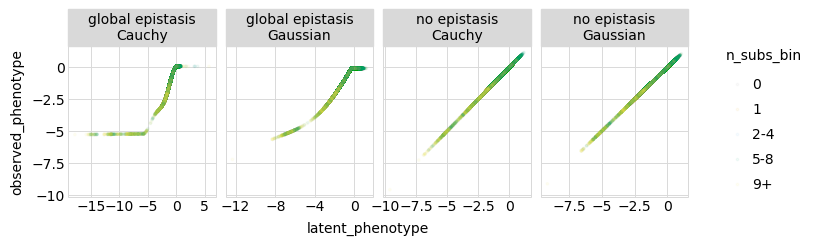

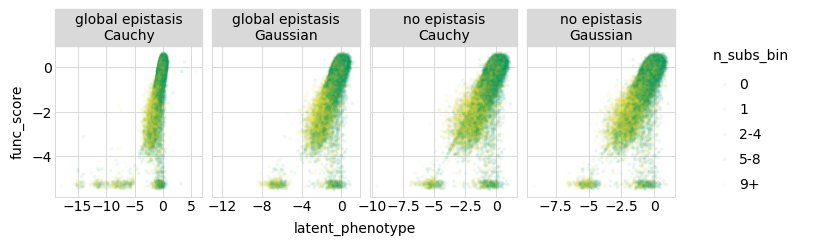

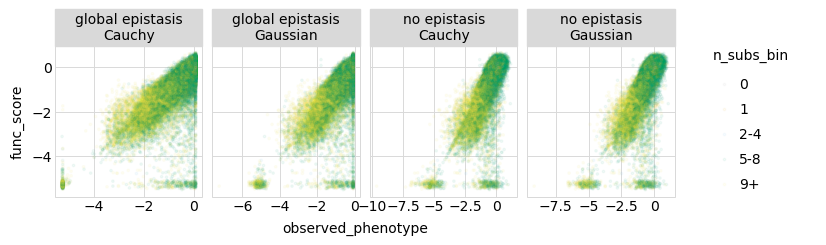

In [29]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df_joint, aes(x, y, color='n_subs_bin')) +
        geom_point(alpha=0.05, size=0.5)
       +facet_grid('~epistasistype+likelihoodtype', scales='free') #+
       +theme(figure_size=(8,2))
        + scale_color_manual(values=CBPALETTE)
       )
    _ = p.draw()
    


## Output epistasis model parameters

In [30]:
# #lib1 models
# models.get(('global epistasis', 'Gaussian', 'lib1')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-latent-effects_expression_1.csv',index=False)
# models.get(('global epistasis', 'Gaussian', 'lib1')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-predicted-effects_expression_1.csv',index=False)
# models.get(('global epistasis', 'Cauchy', 'lib1')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-latent-effects_expression_1.csv',index=False)
# models.get(('global epistasis', 'Cauchy', 'lib1')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-predicted-effects_expression_1.csv',index=False)
# models.get(('no epistasis', 'Gaussian', 'lib1')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Gaussian-predicted-effects_expression_1.csv',index=False)
# models.get(('no epistasis', 'Cauchy', 'lib1')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Cauchy-predicted-effects_expression_1.csv',index=False)
# #lib2 models
# models.get(('global epistasis', 'Gaussian', 'lib2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-latent-effects_expression_2.csv',index=False)
# models.get(('global epistasis', 'Gaussian', 'lib2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-predicted-effects_expression_2.csv',index=False)
# models.get(('global epistasis', 'Cauchy', 'lib2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-latent-effects_expression_2.csv',index=False)
# models.get(('global epistasis', 'Cauchy', 'lib2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-predicted-effects_expression_2.csv',index=False)
# models.get(('no epistasis', 'Gaussian', 'lib2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Gaussian-predicted-effects_expression_2.csv',index=False)
# models.get(('no epistasis', 'Cauchy', 'lib2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Cauchy-predicted-effects_expression_2.csv',index=False)
# #joint models
# models_joint.get(('global epistasis', 'Gaussian')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-latent-effects_expression_joint.csv',index=False)
# models_joint.get(('global epistasis', 'Gaussian')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-predicted-effects_expression_joint.csv',index=False)
# models_joint.get(('global epistasis', 'Cauchy')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-latent-effects_expression_joint.csv',index=False)
# models_joint.get(('global epistasis', 'Cauchy')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-predicted-effects_expression_joint.csv',index=False)
# models_joint.get(('no epistasis', 'Gaussian')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Gaussian-predicted-effects_expression_joint.csv',index=False)
# models_joint.get(('no epistasis', 'Cauchy')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Cauchy-predicted-effects_expression_joint.csv',index=False)




In [31]:
## Correlate to original expression measurements from original Wuhan-1 DMS

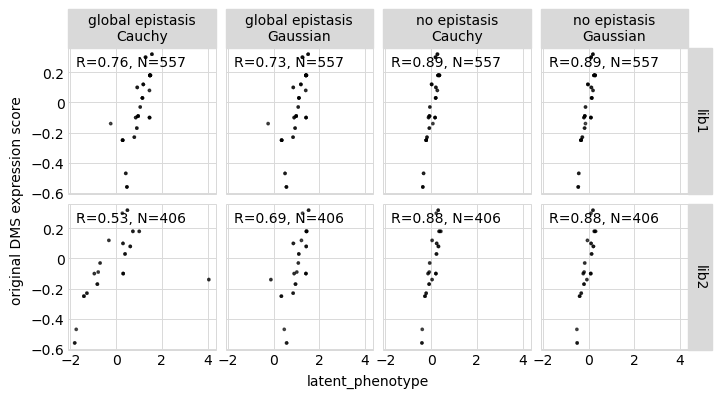

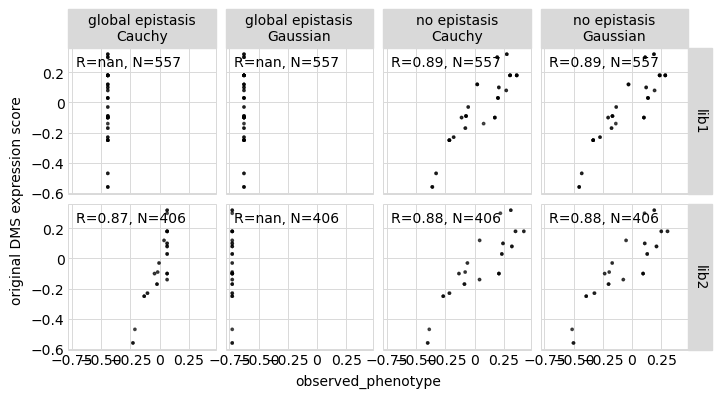

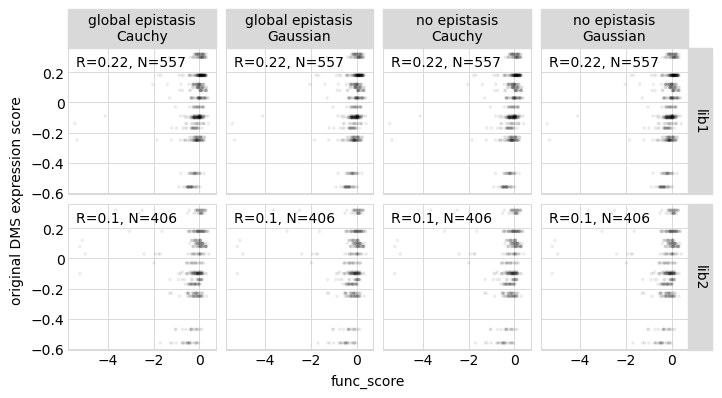

In [32]:
mut_bind_expr = (pd.read_csv(config['mut_bind_expr'])
                 .assign(aa_substitutions=lambda x: x['wildtype']+x['site_RBD'].astype(str)+x['mutant'])
                 [['aa_substitutions', 'expr_avg']]
                 .rename(columns={'expr_avg':'original DMS expression score'})
                )


corr_df = variants_df.merge(mut_bind_expr,
                   how='left',
                   on='aa_substitutions',
                  ).dropna()

len(corr_df)

for x in ['latent_phenotype','observed_phenotype', 'func_score']:
    # correlations between libraries
    corrs = (
        corr_df
        .groupby(['library','likelihoodtype', 'epistasistype'])
        [x, 'original DMS expression score']
        .corr(method='pearson')
        .reset_index()
        .query('level_3 == @x')
        .assign(correlation=lambda x: 'R=' + x['original DMS expression score'].round(2).astype(str))
        [['library', 'likelihoodtype', 'epistasistype', 'correlation']]
        # add number of mutations measured
        .merge(corr_df
               .groupby(['library', 'likelihoodtype', 'epistasistype'])
               .size()
               .rename('n')
               .reset_index()
               )
        .assign(correlation=lambda x: x['correlation'] + ', N=' + x['n'].astype(str))
        )
    
    # plot correlations
    xmin = corr_df[x].min()
    xspan = corr_df[x].max() - xmin
    ymin = corr_df['original DMS expression score'].min()
    yspan = corr_df['original DMS expression score'].max() - ymin
    
    p = (
        ggplot(corr_df, aes(x, 'original DMS expression score')) +
        geom_point(alpha=0.05, size=0.5)+
        geom_text(mapping=aes(label='correlation'),
                   data=corrs,
                   x=0.01 * xspan + xmin,
                   y=0.99 * yspan + ymin,
                   size=10,
                   ha='left',
                   va='top',
                   ) +
       facet_grid('library~epistasistype+likelihoodtype', ) #+scales='free'
       +theme(figure_size=(8,4))
        + scale_color_manual(values=CBPALETTE)
       )
    _ = p.draw()

In [33]:
#! jupyter nbconvert --to markdown global_epistasis_expression.ipynb --output-dir ./results/summary/ --output global_epistasis_expression.md